# Notebook 2.6.4: Epidemiology (Sweeping Parameters)

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

In [2]:
#@title
#@ Import necessary libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')
download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/chap05.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
from ModSimPy_Functions.chap05 import *
import pandas as pd
import numpy as np

Downloaded ModSimPy_Functions/modsim.py
Downloaded ModSimPy_Functions/chap05.py


In the previous notebook we extended the Kermack-McKendrick (KM) model to include immunization and used it to demonstrate herd immunity.  But we assumed that the parameters of the model, contact rate and
recovery rate, were known. In this notebook, we'll explore the behavior of
the model as we vary these parameters.

## Sweeping Beta

Recall that $\beta$ is the contact rate, which captures both the
frequency of interaction between people and the fraction of those
interactions that result in a new infection. If $N$ is the size of the
population and $s$ is the fraction that's susceptible, $s N$ is the
number of susceptibles, $\beta s N$ is the number of contacts per day
between susceptibles and other people, and $\beta s i N$ is the number
of those contacts where the other person is infectious.

As $\beta$ increases, we expect the total number of infections to
increase. To quantify that relationship, I'll create a range of values
for $\beta$:

In [3]:
beta_array = linspace(0.1, 1.1, 11)
gamma = 0.25

We'll start with a single value for `gamma`, which is the recovery rate, that is, the fraction of infected people who recover per day.

The following function takes `beta_array` and `gamma` as parameters.
It runs the simulation for each value of `beta` and computes the same metric we used in the previous chapter, the fraction of the population that gets infected.

The result is a `SweepSeries` that contains the values of `beta` and the corresponding metrics.

In [4]:
def sweep_beta(system,beta_array, gamma):
    sweep = pd.Series([],dtype=object)

    # Unpack variables from original system and return to argument state
    N = system['N']
    iS, iI, iR = system['iS']*N, system['iI']*N,system['iR']*N
    tc, tr, t_end= 1/system['beta'], 1/system['gamma'], system['t_end']

    for beta in beta_array:
        system_local = make_system(iS,iI,iR,1/beta,1/gamma,t_end)
        results = run_simulation(system_local, change_func)
        sweep[beta] = calc_total_infected(results, system_local)
    return sweep

We can run `sweep_beta` like this:

In [5]:
# Create a system
iS = 89; iI = 1; iR = 0    
tc = 3; tr = 4; t_end = 14*7

system = make_system(iS,iI,iR,tc,tr,t_end)
infected_sweep = sweep_beta(system,beta_array, gamma)

Before we plot the results, I will use a formatted string literal, also called an *f-string* to assemble a label that includes the value of `gamma`:

In [6]:
label = f'gamma = {gamma}'
label

'gamma = 0.25'

An f-string starts with the letter `f` followed by a string in single or double quotes. 
The string can contain any number of format specifiers in squiggly brackets, `{}`.
When a variable name appears in a format specifier, it is replaced with the value of the variable.

In this example, the value of `gamma` is `0.25`, so the value of `label` is `'gamma = 0.25'`.

You can read more about f-strings at <https://docs.python.org/3/tutorial/inputoutput.html#tut-f-strings>.

Now let's see the results.

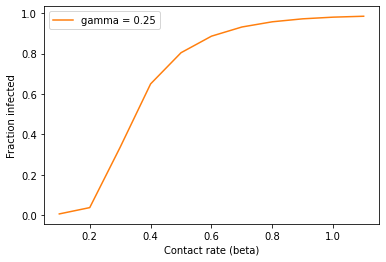

In [7]:
infected_sweep.plot(label=label, color='C1',
                    xlabel='Contact rate (beta)',
                    ylabel='Fraction infected',
                   legend=True);

Remember that this figure
is a parameter sweep, not a time series, so the x-axis is the parameter
`beta`, not time.

When `beta` is small, the contact rate is low and the outbreak never
really takes off; the total number of infected students is near zero. As
`beta` increases, it reaches a threshold near 0.3 where the fraction of
infected students increases quickly. When `beta` exceeds 0.5, more than
80% of the population gets sick.

## Sweeping Gamma

Let's see what that looks like for a few different values of `gamma`.
We'll use `linspace` to make an array of values:

In [8]:
gamma_array = linspace(0.1, 0.7, 4)
gamma_array

array([0.1, 0.3, 0.5, 0.7])

And run `sweep_beta` for each value of `gamma`:

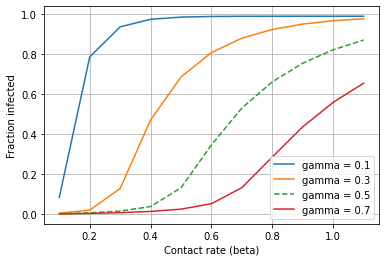

In [15]:
for gamma in gamma_array:
    infected_sweep = sweep_beta(system, beta_array, gamma)
    label = f'gamma = {gamma}'
    if gamma == 0.5:
        infected_sweep.plot(label=label, style='--',
                        xlabel='Contact rate (beta)',
                        ylabel='Fraction infected',
                       legend=True)
    else:
        infected_sweep.plot(label=label,
                        xlabel='Contact rate (beta)',
                        ylabel='Fraction infected', grid=True,
                       legend=True)

When `gamma` is low, the recovery rate is low, which means people are infectious longer.
In that case, even a low contact rate (`beta`) results in an epidemic.

When `gamma` is high, `beta` has to be even higher to get things going.

## Using a DataFrame

In the previous section, we swept a range of values for `gamma`, and for
each value of `gamma`, we swept a range of values for `beta`. This process is a
*two-dimensional sweep*.

If we want to store the results, rather than plot them, we can use a
`DataFrame` where the rows sweep one
parameter, the columns sweep another parameter, and the values contain
metrics from a simulation.

This way we can get a sense of how the two parameters work together: we sweep through `beta` while holding `gamma` steady, then we sweep through `beta` again with a different `gamma` value, etc...

This function shows how it works:

In [10]:
def sweep_parameters(system,beta_array, gamma_array):
    frame = pd.DataFrame([],columns=gamma_array)
    for gamma in gamma_array:
        frame[gamma] = sweep_beta(system,beta_array, gamma)
    return frame

`sweep_parameters` takes as parameters an array of values for `beta` and
an array of values for `gamma`.

It creates a `DataFrame` to store the results, with one column for each
value of `gamma` and one row for each value of `beta`.

Each time through the loop, we run `sweep_beta`. The result is a
`Series` object with one element for each value of `beta`. The
assignment inside the loop stores the `Series` as a new column in
the `DataFrame`, corresponding to the current value of `gamma`.

At the end, the `DataFrame` stores the fraction of students infected
for each pair of parameters, `beta` and `gamma`.

We can run `sweep_parameters` like this:

In [11]:
frame = sweep_parameters(system,beta_array, gamma_array)
frame

,0.1,0.3,0.5,0.7
0.1,0.084693,0.005444,0.002736,0.001827
0.2,0.785673,0.020878,0.007235,0.004367
0.3,0.936118,0.128878,0.015929,0.008129
0.4,0.973692,0.470707,0.038603,0.014242
0.5,0.984596,0.686050,0.132438,0.025708
0.6,0.987757,0.807741,0.346765,0.052853
0.7,0.988620,0.879474,0.530585,0.133248
0.8,0.988834,0.923024,0.661553,0.286258
0.9,0.988880,0.949853,0.754595,0.436999
1.0,0.988888,0.966403,0.821534,0.558946


Looking at this table, we can see that in general as the recovery rate `gamma` (the horizontal axis) gets lower/ quicker, fewer students get infected.  On the other hand, as the contact rate `beta` grows, more students get infected.

Notice that we didn't use the `pd.DataFrame(results)` format that we've used to display `Series` results.   This is because that syntax was simply turning our series into a `'DataFrame` and then displaying it.  Here, `frame` is already a `DataFrame`, so we just enter its name in order to display it.

With the results in a `DataFrame`, we can plot each column like this:

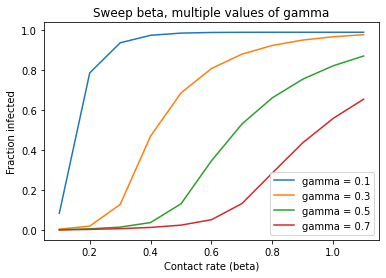

In [12]:
for gamma in gamma_array:
    label = f'gamma = {gamma}'
    frame[gamma].plot(label=label,
                      xlabel='Contact rate (beta)',
                      ylabel='Fraction infected', 
                      title='Sweep beta, multiple values of gamma',
                     legend=True)

Alternatively, we can plot each row like this:

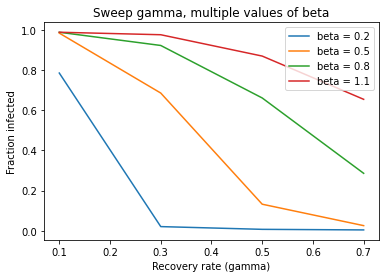

In [13]:
for beta in [0.2, 0.5, 0.8, 1.1]:
    label = f'beta = {beta}'
    frame.loc[beta].plot(label=label,
                         xlabel='Recovery rate (gamma)',
                         ylabel='Fraction infected',
                         title='Sweep gamma, multiple values of beta',
                         legend=True)
                         

This example demonstrates one use of a `DataFrame`: we can run the analysis once, save the results, and then generate different visualizations.

Another way to visualize the results of a two-dimensional sweep is a
*contour plot*, which shows the parameters on the axes and contour
lines where the value of the metric is constant.

The ModSim library provides `contour`, which takes a `DataFrame` and uses Matplotlib to generate a contour plot.

[Text(0, 0.5, 'Contact rate (beta)'),
 Text(0.5, 0, 'Recovery rate (gamma)'),
 Text(0.5, 1.0, 'Contour plot, fraction infected')]

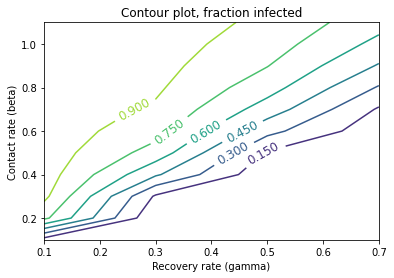

In [14]:
contour(frame)

#  The next two lines use gca to "Get Current Axes", and then set
# the options for axes.  This is from the matplotlib library
ax = plt.gca()
ax.set(xlabel='Recovery rate (gamma)',
        ylabel='Contact rate (beta)',
        title='Contour plot, fraction infected')

The values of `gamma` are on the $x$-axis, corresponding to the columns of the `SweepFrame`.
The values of `beta` are on the $y$-axis, corresponding to the rows of the `SweepFrame`.

Infection rates are lowest in the lower right, where the contact rate is low and the recovery rate is high. They increase as we move to the upper left, where the contact rate is high and the recovery rate is low.



## Summary

This chapter demonstrates a two-dimensional parameter sweep using a `SweepFrame` to store the results.

We plotted the results three ways: 

* First we plotted total infections versus `beta`, with one line for each value of `gamma`.

* Then we plotted total infections versus `gamma`, with one line for each value of `beta`.

* Finally, we made a contour plot with `beta` on the $y$-axis, `gamma` on the $x$-axis and contour lines where the metric is constant.

These visualizations suggest that there is a relationship between `beta` and `gamma` that determines the outcome of the model. 
In fact, there is.
In the next chapter we'll explore it by running simulations, then derive it by analysis.

### Exercise 1

Now that we have created the sweep plots above, if we know `beta` and `gamma`, we can compute the fraction of the population that gets infected.  In general, we don't know these parameters, but sometimes we can estimate them based on the behavior of an outbreak.

<br>

✅ ✅ A.  Suppose the recovery period for the Freshman Plague is known to be 2 days on average, and suppose during one particularly bad year, 40% of the class is infected at some point.  Use the plots generated in this chapter to estimate the time between contacts, `1/beta`.  Note: this is not asking you to write any new code--you can answer the question just by reading the any of the 3 plots in the last section of this notebook.

<br> Confirm your answer by reading at least two of the plots.

✅ ✅ Write your answer here, and say which plots you used.

✅ ✅ B.  Look at the contour plot (the last plot in the notebook).  As the 'fraction infected' goes up, what tends to happen to the `beta`, recovery period, `gamma`, and average contact time?

✅ ✅  B.  Finish these sentences:

 `beta` tends to ...  (go up/ go down).

The recovery time tends to...

`gamma` tends to ...

The average period between contact tends to ...

Explain in a sentence or two why this makes sense in terms of the physical system.